### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle

# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
from Env import CabDriver

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


#### Defining Time Matrix

In [2]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")
env = CabDriver()
epsiode_length = 24*30

#### Tracking the state-action pairs for checking convergence


In [3]:
#Defining a function to save the Q-dictionary as a pickle file
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state-action and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [4]:
class DQNAgent:
    
    def __init__(self, state_size, action_size, discount_factor=0.95, learning_rate=0.01,
                       epsilon=1, epsilon_decay=0.99, epsilon_min=0.01):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size + 1 # +1 for the no_idle
        self.discount_factor = discount_factor
        self.epsilon = 1.0
        self.learning_rate = learning_rate      
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay 
        self.epsilon_min = epsilon_min
        self.batch_size = 32     
        self.state_encoded = 36 # (m + t + d)
        # create replay memory using deque
        self.memory = deque(maxlen=2000)
        # create main model and target model
        self.model = self.build_model()


    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        model.add(Dense(32, input_dim=self.state_encoded, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))
        # model.summary()
        model.compile(loss='mse',optimizer=Adam(learning_rate=self.learning_rate))
        return model


    def get_action(self, state):
        """
        get action in a state according to an epsilon-greedy approach
        """
        indexes, actions = env.requests(state)
        # print(f'indexes: {indexes}, actions : {actions}')
        if np.random.rand() <= self.epsilon:
            # get possible requests/actions given a state
            # choose an action randomly, this will contain the no-ride action
            return random.choice(actions)
        else:
            # get q_value for all actions = this should be 21 (20 actions + no ride)
            state_encoded = env.state_encod_arch2(state)
            state_encoded = np.reshape(state_encoded, [1, self.state_encoded])
            q_value = self.model.predict(state_encoded)
            # print(f'q_value..{q_value}')
            # get q_values for the actions/requests which the cab driver received
            # the index should include the index for no-ride
            filtered_q_values = [q_value[0][i] for i in [indexes]]
            # print(f'filtered_q_value..{filtered_q_values}')
            # get the index with max q-value
            max_q_value_index = np.argmax(filtered_q_values)
            # print(f'max_q_value_index..{max_q_value_index}')
            return actions[max_q_value_index]
        

    def append_sample(self, state, action, reward, next_state, hours_of_trip):
        # append the tuple (s, a, r, s', done) to memory (replay buffer) after every action
        self.memory.append((state, action, reward, next_state, hours_of_trip))

        # Decay in ε after we generate each sample from the environment
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    

    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):

        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_output = np.zeros((self.batch_size, self.state_encoded))
            update_input = np.zeros((self.batch_size, self.state_encoded))
            action, rewards, trip_hours_per_exp = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, hours_of_trip = mini_batch[i]
                state_encod = env.state_encod_arch2(state)
                next_state_encod = env.state_encod_arch2(next_state)
                update_input[i] = state_encod
                update_output[i] = next_state_encod
                rewards.append(reward)
                trip_hours_per_exp.append(hours_of_trip)
                
            # Write your code from here
            # 1. Predict the target from earlier model
            target = self.model.predict(update_input)   
                
            # 2. Get the target for the Q-network
            target_qval = self.model.predict(update_output)

            for i in range(self.batch_size):
                # find if it is the terminal state
                if (trip_hours_per_exp[i] >= epsiode_length):
                    # if it is the terminal state (i.e. if it is the end of the month) then the target q value is just the reward
                    target[i] = rewards[i]
                else:
                    # if it is not terminal state then the target value = reward + discount * (max(q(next_state, a)))
                    target[i] = rewards[i] + self.discount_factor * (np.amax(target_qval[i]))

            #3. Update your 'update_output' and 'update_input' batch. Be careful to use the encoded state-action pair
            self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=0)
                
                
        # 4. Fit your model and track the loss values

    def save(self, name):
        self.model.save_weights(name)

In [5]:
# Testing code. 
state_size = len(env.state_space)
action_size = len(env.action_space) + 1 # for no-ride
agent = DQNAgent(state_size, action_size)
state = env.state_init
print(state)
action = agent.get_action(state)
print(action)
state, action, reward, next_state, trip_hours = env.step(state, action, Time_matrix, 0)
# print(state, action, reward, next_state, trip_hours)

(4, 8, 1)
(3, 4)


In [6]:
Episodes = 10
state_size = len(env.state_space)
action_size = len(env.action_space) + 1 # for no-ride

### DQN block

In [7]:
for episode in range(Episodes):

    # Call the environment
    env = CabDriver()

    # Call all the initialised variables of the environment
    state_size = len(env.state_space)
    action_size = len(env.action_space) + 1 # for no-ride
    initial_state = env.state_init
    current_state = env.state_init
    #Call the DQN agent 
    agent = DQNAgent(state_size, action_size)
    steps = 0 # cab driver starts with 0 trip hours
    total_reward = 0
    
    while steps <= 24 * 30: # each episode is 30 days long
        
        # print(f'starting state...{steps}')
        
        # 1. Pick epsilon-greedy action from possible actions for the current state
        action = agent.get_action(current_state)

        # 2. Evaluate your reward and next state
        state, action, reward, next_state, hours_of_trip = env.step(current_state, action, Time_matrix, steps)
        # print(state, action, reward, next_state, hours_of_trip)

        # 3. Append the experience to the memory
        agent.append_sample(current_state, action, reward, next_state, hours_of_trip)
        
        # 4. Train the model by calling function agent.train_model
        agent.train_model()

        # Numer of days completed = steps, the episode ends when 30 days are completed
        steps += hours_of_trip 

        current_state = next_state

        # 5. Keep a track of rewards, Q-values, loss
        total_reward += reward

    #save the model 
    if episode % 50 == 0:
        agent.model.save_weights("./models/supercabs.h5")

    print(f'Episode: {episode} Total Reward: {total_reward}, epsilon: {agent.epsilon}')
        
        

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp9qg411c2.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: invalid syntax (tmp9qg411c2.py, line 48)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Episode: 0 Total Reward: -71, epsilon: 0.3024044356690215
Episode: 1 Total Reward: -232, epsilon: 0.24983705645845267
Episode: 2 Total Reward: -73, epsilon: 0.19046145976502743
Episode: 3 Total Reward: -279, epsilon: 0.20230002712877712
Episode: 4 Total Reward: -154, epsilon: 0.3024044356690215
Episode: 5 Total Reward: -114, epsilon: 0.18112695312597027
Episode: 6 Total Reward: -158, epsilon: 

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [8]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

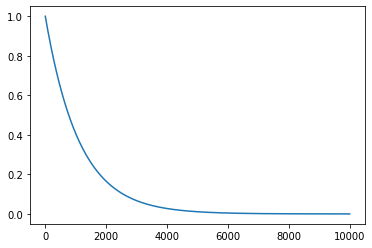

In [9]:
plt.plot(time, epsilon)
plt.show()